# Quantum Graph Recurrent Neural Network

Builds upon the [tutorial from pennylane](https://pennylane.ai/qml/demos/tutorial_qgrnn.html) which implements the idea from [this paper](https://arxiv.org/abs/1909.12264).

In [1]:
import numpy as np

import matplotlib.pyplot as plt

from qiskit import QuantumCircuit
from qiskit.algorithms.optimizers import ADAM , SPSA
from qiskit.circuit import Parameter, ParameterVector
from qiskit.opflow import H, I, X, Y, Z, Zero, One, StateFn, CircuitOp, PauliExpectation
from qiskit.opflow.primitive_ops import MatrixOp

import networkx as nx

Considering quadratic Hamiltonians, we can interpret those as a graph model where quadratic terms represent interactions between two qubits (edges) and linear terms the energy of individual qubits (nodes).
A common example of a quadratic Hamiltonian would be the following transverse-field Ising model
$$\mathrm H_{\text{Ising}}(\boldsymbol\theta) \ = \ \displaystyle\sum_{(i, j) \in E}
\theta_{ij}^{(1)} \mathrm Z_{i} \mathrm Z_{j} \ + \ \displaystyle\sum_{i} \theta_{i}^{(2)} \mathrm Z_{i} \ + \
\displaystyle\sum_{i} \mathrm X_{i},$$
where $\boldsymbol\theta \ = \ \{\theta^{(1)}, \ \theta^{(2)}\}$ realize parameters characterizing the interactions and energies respectively.

We can create a circuit using this formulation by recalling that the time-evolution operator w.r.t. some Hamiltonian $\mathrm H$ is defined as:

$$\mathrm U_{\text {Ising }}=e^{-i t \mathrm{H}_{\text {Ising }}(\theta)}=\exp \left[-i t\left(\sum_{(i, j) \in E} \theta_{i j}^{(1)} \mathrm Z_i \mathrm Z_j+\sum_i \theta_i^{(2)} \mathrm Z_i+\sum_i \mathrm X_i\right)\right]$$

We can approximate this unitary expression using the Trotter-Suzuki decomposition (aka. *Trotterization* as introduced in the lecture):

$$
\mathrm{e}^{A+B}=\lim _{n \rightarrow \infty}\left(\mathrm{e}^{\frac{A}{n}} \mathrm{e}^{\frac{B}{n}}\right)^n
$$

Applying this on the unitary stated above, we find that for a finite number $n=\frac{t}{\Delta}$, we can approximate the evolution over an interval $t$ as follows:

$$\exp \left[ -it \left( \displaystyle\sum_{(i, j) \in E} \theta_{ij}^{(1)} \mathrm Z_{i} \mathrm Z_{j} \ + \
\displaystyle\sum_{i} \theta_{i}^{(2)} \mathrm Z_{i} \ + \ \displaystyle\sum_{i} \mathrm X_{i} \right) \right]
\ \approx \ \displaystyle\prod_{k \ = \ 1}^{t / \Delta} e^{-i \Delta \mathrm H_{\text{Ising}}(\boldsymbol\theta)}$$

and in a more general way for $Q$ parts of the Hamiltonian:

$$\exp \left[ -it \left( \displaystyle\sum_{(i, j) \in E} \theta_{ij}^{(1)} Z_{i} Z_{j} \ + \
\displaystyle\sum_{i} \theta_{i}^{(2)} \mathrm Z_{i} \ + \ \displaystyle\sum_{i} \mathrm X_{i} \right) \right]
\ \approx \ \displaystyle\prod_{k \ = \ 1}^{t / \Delta} \left[ \displaystyle\prod_{j \ = \
1}^{Q} e^{-i \Delta \mathrm H^{j}(\boldsymbol\theta)} \right]$$

where $\mathrm H_{\text{Ising}}^{j}(\boldsymbol\theta)$ is the $j$-th term
of the Ising Hamiltonian and $\Delta$ is some small number.

The unitary expression for a single QRGNN layer thus becomes:

$$\mathrm U_{\mathrm{H}_{\text {Ising}}}(\boldsymbol{\theta}, \Delta t) = e^{-i t_k \mathrm{H}_{\text {Ising }}(\boldsymbol{\theta})}$$



Now, that we defined the unitary expression for the Ising model, we must think about the general approach to learn its parameters.
In the end, what we want is a *learnable* Hamiltonian $H'$ which, given a time interval $t_k$, should produce a state $\psi'$ that is equivalent to the state $\psi$ evolved by a reference Hamiltonian $H$.
Finding the similarity between these two states and given the same set of input states also the similarity between the Hamiltonians, can be done using the **SWAP-Test**.

The overall architecture then looks like this:

<div>
<img src="./qrgnn_overview.png" width="800"/>
</div>


In this example, we are going to work with a $4$ qubit Hamiltonian.
However, the overall circuit will feature $9$ qubits in total, as we need the same number of qubits for the reference Hamiltonian and one additional qubit for the fidelity measurement.

In [2]:
state_n_qubits = 4

The interaction graph should be a cyclic graph with the number of nodes equal to the number of qubits.

Edges: [(0, 1), (0, 3), (1, 2), (2, 3)]


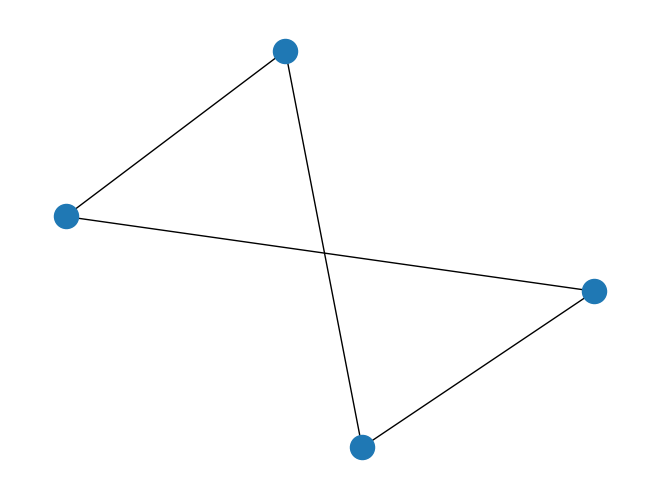

In [3]:
ising_graph = nx.cycle_graph(state_n_qubits)

print(f"Edges: {ising_graph.edges}")
nx.draw(ising_graph)

There exist several ways how we can construct the Hamiltonian. We can either use completely Qiskit's Opflow API or, to maintain comparability with the Pennylane example, construct the Hamiltonian matrix directly by adding up each of the individual terms in the Hamiltonian.

Note that the following code constructs the Hamiltonian depending on the structure provided by the ```graph``` variable.

In [4]:
def create_hamiltonian(graph):
    n_qubits = len(graph.nodes)

    # Introducing edge and node parameters. We can specify those later
    # after creating the structure of the Hamiltonian.
    edge_weights = ParameterVector("edge_", len(graph.edges))
    node_weights = ParameterVector("node_", n_qubits)
   
    full_matrix = MatrixOp(np.zeros((2**n_qubits, 2**n_qubits)))

    for i, edge in enumerate(graph.edges):
        interaction_term = 1
        for qubit in range(0, n_qubits):
            if qubit in edge:
                interaction_term ^= Z
            else:
                interaction_term ^= I
    
        full_matrix += edge_weights[i] * interaction_term
    
    for i, node in enumerate(graph.nodes):
        z_term = x_term = 1
        for qubit in range(0, n_qubits):
            if qubit == node:
                z_term ^= Z
                x_term ^= X
            else:
                z_term ^= I
                x_term ^= I
    
        full_matrix += node_weights[i] * z_term + x_term
    
    return full_matrix, edge_weights, node_weights

By specifying some target edge and node weights, we can visualize aforementioned matrix of the Hamiltonian.

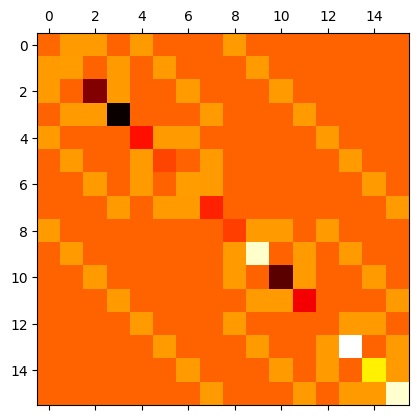

In [5]:
target_edge_weights = np.array([0.56, 1.24, 1.67, -0.79])
target_node_weights = np.array([-1.44, -1.43, 1.18, -0.93])


# Prints a visual representation of the Hamiltonian matrix
ham_matrix, edge_weights, node_weights = create_hamiltonian(ising_graph)

    
ham_matrix_ref = ham_matrix.bind_parameters(
    {
        **{p: w for p, w in zip(edge_weights, target_edge_weights)},
        **{p: w for p, w in zip(node_weights, target_node_weights)}
    }
)

plt.matshow(ham_matrix_ref.to_matrix().real, cmap="hot")
plt.show()

Next we define the low energy state from which we want to evolve the Hamiltonian. These values can be obtained by early terminating a VQE experiment or by running a VQE algorithm with an unprecise Ansatz such that it cannot learn the exact ground state.

In [6]:
low_energy_state = StateFn([
    (-0.054661080280306085 + 0.016713907320174026j),
    (0.12290003656489545 - 0.03758500591109822j),
    (0.3649337966440005 - 0.11158863596657455j),
    (-0.8205175732627094 + 0.25093231967092877j),
    (0.010369790825776609 - 0.0031706387262686003j),
    (-0.02331544978544721 + 0.007129899300113728j),
    (-0.06923183949694546 + 0.0211684344103713j),
    (0.15566094863283836 - 0.04760201916285508j),
    (0.014520590919500158 - 0.004441887836078486j),
    (-0.032648113364535575 + 0.009988590222879195j),
    (-0.09694382811137187 + 0.02965579457620536j),
    (0.21796861485652747 - 0.06668776658411019j),
    (-0.0027547112135013247 + 0.0008426289322652901j),
    (0.006193695872468649 - 0.0018948418969390599j),
    (0.018391279795405405 - 0.005625722994009138j),
    (-0.041350974715649635 + 0.012650711602265649j),
])

Nonetheless we can calculate the exact ground state using Numpys Eigensolver and compare it with the energy calculated from the inner product of the state with the Hamiltonian created earlier.

In [7]:
res = (~low_energy_state @ ham_matrix_ref @ low_energy_state).eval()
energy_exp = np.real_if_close(res)
print(f"Energy Expectation: {energy_exp}")

ground_state_energy = np.real_if_close(min(np.linalg.eig(ham_matrix_ref.to_matrix())[0]))
print(f"Ground State Energy: {ground_state_energy}")

Energy Expectation: -7.244508985189116
Ground State Energy: -7.330689661291247


We are going to assume, that we don't know the structure of the Ising graph, thus our learnable Hamiltonian will be generated from a fully connected graph.

Edges: [(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]


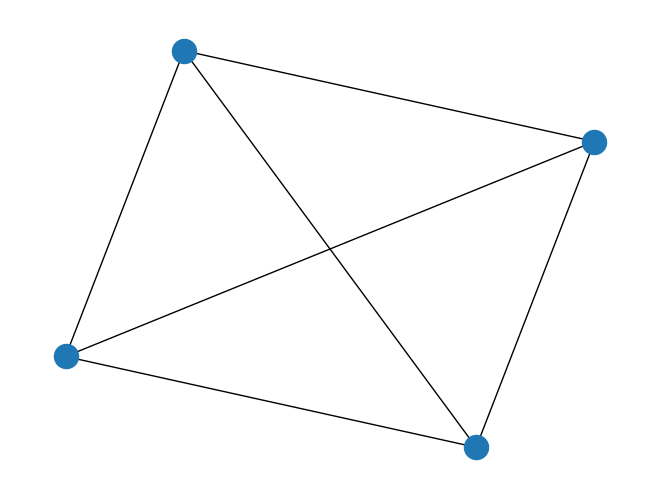

In [8]:
ising_graph_full = nx.complete_graph(state_n_qubits)

ham_matrix_full, edge_weights_full, node_weights_full = create_hamiltonian(ising_graph_full)

print(f"Edges: {ising_graph_full.edges}")
nx.draw(ising_graph_full)

For the swap state we're going to create a circuit as usual and translate it into a circuit operation to match the Opflow API.

In [9]:
qc = QuantumCircuit(2*state_n_qubits+1)

qc.h(2*state_n_qubits)
for i in range(state_n_qubits):
    qc.cswap(2*state_n_qubits,i,i+state_n_qubits)
qc.h(2*state_n_qubits)
swap_test = CircuitOp(qc)

print(swap_test)

                           
q_0: ──────X───────────────
           │               
q_1: ──────┼──X────────────
           │  │            
q_2: ──────┼──┼──X─────────
           │  │  │         
q_3: ──────┼──┼──┼──X──────
           │  │  │  │      
q_4: ──────X──┼──┼──┼──────
           │  │  │  │      
q_5: ──────┼──X──┼──┼──────
           │  │  │  │      
q_6: ──────┼──┼──X──┼──────
           │  │  │  │      
q_7: ──────┼──┼──┼──X──────
     ┌───┐ │  │  │  │ ┌───┐
q_8: ┤ H ├─■──■──■──■─┤ H ├
     └───┘            └───┘


Next, we define a single layer of our QRGNN which binds the parameters to the Hamiltonian created by the fully connected graph and evolves the result by a given times step.

In [10]:
def qgrnn_layer(edge_values, node_values, time_step):
    ham_matrix_step = ham_matrix_full.bind_parameters(
        {
            **{p: w for p, w in zip(edge_weights_full, edge_values)},
            **{p: w for p, w in zip(node_weights_full, node_values)}
        }
    )
    
    evolution_op = (time_step*ham_matrix_step).exp_i()

    return evolution_op

Since we are are only interested in the outcome of the $8$-th qubit, we can create a measurement state with a Pauli-Z on the last qubit and identities everywhere else.
This then will give us the fidelity in a range between $[-1 \dots 1]$.

$$\langle \psi_\text{fidelity\_meas} \vert \mathrm U_\text{swap\_test} \otimes e^{-i t_k \mathrm{H'}_{\text {Ising }}(\boldsymbol{\theta})} \otimes e^{-i t_k \mathrm{H}_{\text {Ising }}} \vert \psi_0 \otimes \psi_\text{low\_energy\_state} \otimes \psi_\text{low\_energy\_state} \rangle$$

In [11]:
fidelity_meas = StateFn(Z^(I^(state_n_qubits*2))).adjoint()
fidelity_meas = PauliExpectation(group_paulis=False).convert(fidelity_meas)

Finally we can compose all operations in a single method which returns the costs for a single sample.
To implement the trotterization we repeat the ```qrgnn_layer``` several times as defined by the ```trotter_step``` $\Delta$.

In [12]:
trotter_step = 0.01  # Trotter step size

def qrgnn(edge_values, node_values, time):
    reference_hamiltonian = (time*ham_matrix_ref).exp_i()

    learned_hamiltonian = I^4
    for _ in range(int(time / trotter_step)):
        learned_hamiltonian = qgrnn_layer(edge_values, node_values, trotter_step) @ learned_hamiltonian

    return fidelity_meas @ swap_test @ (I^(learned_hamiltonian^reference_hamiltonian)) @ (Zero^(low_energy_state^2))


For training purposes we set up some initial values as well as the number of samples $N$ that we evaluate before we do a parameter update.
Additionally we specify the overall time intervall in which we want to evolve the Hamiltonian (this is $t_k$).

In [13]:
N = 15  # The number of pieces of quantum data that are used for each step
max_time = 0.1  # The maximum value of time that can be used for quantum data

rng = np.random.default_rng(seed=42)

init_edge_values = rng.random(size=len(ising_graph_full.edges)) - 0.5
init_node_values = rng.random(size=state_n_qubits) - 0.5

To get a fidelity measure between $[0\dots 1]$ as we are used to from the pseudo probabilities, we need to shift the result by $1$ and divide everything by $2$.

In [14]:
(1 + (qrgnn(init_edge_values, init_node_values, time=0.1)).eval().real)/2

0.9753430003499253

Last but not least, we specify the cost function which essentially averages the costs over the numer of samples $N$ and splits up the parameters obtained from the optimizer accordingly.

In [15]:

def cost_function(all_values):
    edge_values = all_values[:len(ising_graph_full.edges)]
    node_values = all_values[len(ising_graph_full.edges):]

    # Randomly samples times at which the QGRNN runs
    times_sampled = rng.random(size=N) * max_time

    # Cycles through each of the sampled times and calculates the cost
    total_cost = 0
    for dt in times_sampled:
        result = qrgnn(edge_values, node_values, time=dt).eval().real
        total_cost += -1 * result

    return total_cost / N




As in the VQE example we use the SPSA optimizer for which we define a callback method and the starting point by concatinating the edge and node values.

In [16]:
x0 = np.array([*init_edge_values, *init_node_values])
loss = []
params = []
best_params = x0

def callback(n_t, params_t, fun_t, *args, **kwargs):
    global loss, params, best_params
    print(f"Epoch \t {len(loss)}")
    print(f"Loss:\t{fun_t}")
    print(f"Params:\t{params_t}")

    loss.append(fun_t)
    params.append(params_t)

    if fun_t <= min(loss):
        best_params = params_t

opt = SPSA(maxiter=200, callback=callback)

In [17]:
result = opt.minimize(fun=cost_function, x0=x0)

Epoch 	 0
Loss:	-0.9836458603403012
Params:	[ 1.46824578 -1.25541129  1.55288765 -0.9969217   0.78846708 -0.71866738
  1.45542944 -0.90822543  0.82240337 -1.2439038 ]
Epoch 	 1
Loss:	-0.9798375215873847
Params:	[ 0.84171176 -0.62887727  0.92635363 -0.37038768  1.4150011  -0.09213336
  2.08196346 -1.53475945  1.44893739 -0.61736977]
Epoch 	 2
Loss:	-0.9917014631079701
Params:	[ 0.15631445  0.05652004  1.61175094  0.31500963  0.72960379 -0.77753067
  1.39656615 -2.22015676  0.76354008  0.06802754]
Epoch 	 3
Loss:	-0.9882116172103292
Params:	[ 0.45236385  0.35256943  1.31570155  0.01896023  1.02565319 -1.07358006
  1.69261554 -2.51620615  0.46749068 -0.22802186]
Epoch 	 4
Loss:	-0.9890683786089925
Params:	[ 0.39858513  0.40634815  1.36948026  0.07273895  1.0794319  -1.01980135
  1.74639426 -2.56998487  0.41371197 -0.28180057]
Epoch 	 5
Loss:	-0.9930959468917225
Params:	[-0.10201762  0.9069509   0.86887751  0.5733417   0.57882915 -0.5191986
  2.24699701 -3.07058762  0.91431472 -0.78240333]

We can obtain the learned edge and node values either from the result of the optimizer or use the saved parameters from the callback function.
Together with the initial parameters we then can bind those to the full hamiltonian matrix representation and compare it with the target hamiltonian altogether.

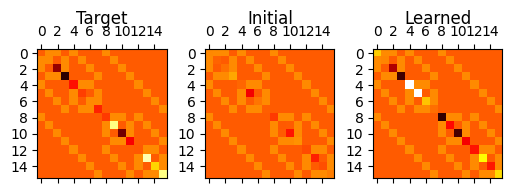

In [18]:
learned_edge_values = best_params[:len(ising_graph_full.edges)]
learned_node_values = best_params[len(ising_graph_full.edges):]

ham_matrix_learned = ham_matrix_full.bind_parameters(
        {
            **{p: w for p, w in zip(edge_weights_full, learned_edge_values)},
            **{p: w for p, w in zip(node_weights_full, learned_node_values)}
        }
    )

ham_matrix_init = ham_matrix_full.bind_parameters(
        {
            **{p: w for p, w in zip(edge_weights_full, init_edge_values)},
            **{p: w for p, w in zip(node_weights_full, init_node_values)}
        }
    )

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(6, 6))

axes[0].matshow(ham_matrix_ref.to_matrix().real, vmin=-7, vmax=7, cmap="hot")
axes[0].set_title("Target", y=1.13)

axes[1].matshow(ham_matrix_init.to_matrix().real, vmin=-7, vmax=7, cmap="hot")
axes[1].set_title("Initial", y=1.13)

axes[2].matshow(ham_matrix_learned.to_matrix().real, vmin=-7, vmax=7, cmap="hot")
axes[2].set_title("Learned", y=1.13)

plt.subplots_adjust(wspace=0.3, hspace=0.3)
plt.show()

reference:	[ 0.56  1.24  1.67 -0.79]
initial:	[ 0.27395605 -0.06112156  0.35859792  0.19736803 -0.40582265  0.47562235]
learned:	[-0.36630433  1.59475712  1.47835192 -0.08314436  0.11949687 -0.20665136]


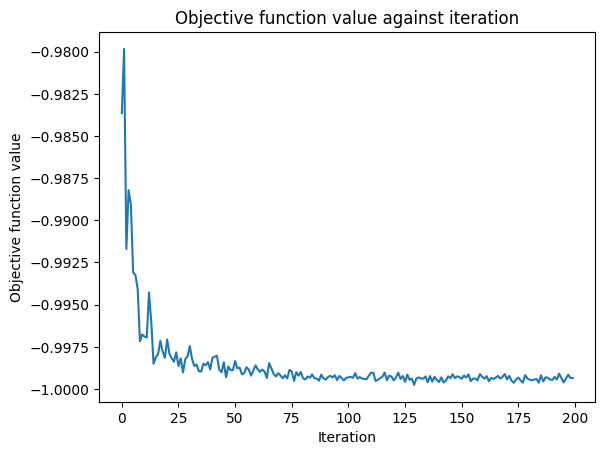

In [19]:
print(f"reference:\t{target_edge_weights}\ninitial:\t{init_edge_values}\nlearned:\t{learned_edge_values}")

plt.title("Objective function value against iteration")
plt.xlabel("Iteration")
plt.ylabel("Objective function value")
plt.plot(loss)
plt.show()